In [7]:
from iminuit import Minuit
from scipy.stats import norm
from scipy.optimize import fmin, fmin_bfgs,minimize, curve_fit, SR1,BFGS
from scipy.stats import rv_continuous
from iminuit.util import describe, make_func_code
import numpy as np
import math
import sys
import matplotlib.pyplot as plt


## Iminuit example

We will make a "classical" example starting from the scikit-hep package iminuit!

This together with other packages can be found in the page scikit-hep:

https://scikit-hep.org/

The documentation specific to iminuit can be found here:

https://iminuit.readthedocs.io/en/stable/

## Step 1: metrics

Any minimization, or "fit procedure", requires a metrics to minimize. 

Iminuit allows to customize this metrics, by defining an ad-hoc class, while

In [13]:
#Let's first define the metrics, simple chi2 
def chi2(model,x,y,sigma,*par):
    return ((model(x,*par)-y)/sigma)**2

class leastsquares:
    def __init__(self,model,xs,ys,sigmas):# here I initialize the class with a constructor 
        self.model=model
        self.xs=xs
        self.ys=ys
        self.sigmas=sigmas
    def __call__(self, *par):# once I initialized I can call the class as a function of the arguments *par
        chitot=0
        for i in range(len(self.xs)):
            chitot=chitot+chi2(self.model,self.xs[i],self.ys[i],self.sigmas[i],*par)
        return chitot

In [23]:
#Define metrics: negative log likelihood
class nll:
    def __init__(self,model,x):
        self.x=x
        self.model=model
    def __call__(self, *par):
        return np.sum([-2*math.log(self.model(xi,*par)) for xi in self.x])


In [24]:
class gaussian_gen(rv_continuous):#this is how inheritance is set up in python:
#here gaussian_gen inherits all methods from the class rv_continuous of scipy stats
    
    def set_pars(self,mean,sigma):#define a custom method to set some parameters
        self.mean=mean
        self.sigma=sigma
    
    def _pdf(self, x):#here I implement the concrete version of the abstract method _pdf, which evaluates the probability density 
        return np.exp(-(x-self.mean)**2 / (2.*self.sigma**2)) / (self.sigma*np.sqrt(2.0 * np.pi))

## Let's setup the functions
1. Linear fit
2. Gaussian fit 

In [25]:
print("Simple Fitting procedure!")


#Linear function      
linear = lambda x,a,b : a+b*x
gaussian = lambda x,mu,sigma : 1/(sigma*np.sqrt(2*math.pi)) * np.exp(-(x-mu)*(x-mu) / (2* sigma*sigma) )

#Those are equivalent to:
def linear_func(x,a,b):
    return a +b*x
def gaussian_func (x,mu,sigma,n):
    return 1/(sigma*math.sqrt(2*math.pi)) * math.exp(-(x-mu)*(x-mu) / (2* sigma*sigma) )
  

Simple Fitting procedure!


# Example #1.1 linear fit 

In [26]:
a=2
b=1
 
#let's make some numbers 
xsm=[0,1.1,4]
xss=[.1,.1,.1]
    
    
#norm comes from scipy 
#normfunction = norm(mean,sigma) rvs means random variates: returns a random value according to the pdf.
ys=[linear(norm(x[0],x[1]).rvs(),a,b) for x in zip(xsm,xss)] #We generate ys from the parameters a and b, but by fluctuating them.
#this is the equivalent to:
ys2=[]
for i in range(len(xsm)):
    xmean_i=xsm[i]
    sigma_i=xss[i]
        
    random_x=norm(xmean_i,sigma_i).rvs()
    yi= linear(random_x,a,b)
    ys2.append(yi)

print(" xs ", xsm , " ys 1 ", ys , " ys 2 ",ys2)
    
ls=leastsquares(linear,xsm,ys,xss)
    
print(ls(a,b))#this uses the __call__ function inside of a class
    
m1 = Minuit(ls,a,b) #now I add a minimizing algorithm, for example minuit
m1.migrad()
m1.hesse()
    
    
scipy_min= fmin(lambda args:ls(args[0],args[1]) , [a,b],full_output=True, disp=False)
#this is one option, but doesn't evaluate hessian
    
scipy_min= fmin_bfgs(lambda args:ls(args[0],args[1]) , [a,b],full_output=True, disp=False)
#this option evaluates hessian
    
#now printing all values
print("printing all parameters from minuit minimization")
print ( m1.params )
print("printing covariance matrix")
print ( m1.covariance )

#to get the parameters and the errors you do:
print ("to get the values and errors use .values and .print ")
print ( m1.values )
print ( m1.errors )

print("Now printing the scipy minimum with scipi.optimize.fmin_bfgs", scipy_min)
#note this is a different minimization method! 

 xs  [0, 1.1, 4]  ys 1  [1.9749851899761586, 3.1381985334168094, 5.975916062984427]  ys 2  [2.120372715685266, 3.153197295694041, 6.028613510339177]
0.2664904697894054
printing all parameters from minuit minimization
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   2.00    │   0.08    │            │            │         │         │       │
│ 1 │ x1   │   0.996   │   0.034   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
printing covariance matrix
┌────┬───────────────────┐
│    │       x0       x1 │
├────┼───────────────────┤
│ x0 │  0.00672 -0.00199 │
│ x1 │ -0.00199  0.00117 │
└────┴───────────────────┘
to get the values and errors use .values and .pr

/tmp/ipykernel_27275/465287786.py:29: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m1.migrad()


## Fit sanity checks 
How do I understand if the fit works?

#1) Have a figure of merit, or a metrics for the fit quality
#2) Perform bias tests: if the fit has some bias in the obtaned parameters

if the fit works correctly, then usually the parameter is centered around the fitted value with a variance = error^2 

# In practice:

Perform the fit several  times  by having data - or pseudo-data to fluctuate according to their pdf.

In this case means : generate a lot of fits!
    

In [27]:
#I generate a lot of pseudoexperiments:
pulls_a=[]
pulls_b=[]
for i in range(1000):
    y_i=[linear(norm(x[0],x[1]).rvs(),a,b) for x in zip(xsm,xss)] 
    ls_i = leastsquares(linear, xsm,y_i,xss)
    m_i = Minuit(ls_i,a,b) 
    m_i.migrad()
    m_i.migrad()
    m_i.hesse()
    #        print(" a ", a, "m_i ",m_i.values[0])
    pull_a_i = (a-m_i.values[0])/m_i.errors[0]
    pulls_a.append(pull_a_i)

print("pulls mean is: " ,np.mean(pulls_a))#numpy mean 
print("pluss standard deviation is : ",np.std(pulls_a))#numpy) standard deviation 

/tmp/ipykernel_27275/2652031955.py:8: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m_i.migrad()


pulls mean is:  -0.008562582790703743
pluss standard deviation is :  1.0075460101010472


# Example 1.2: Gaussian fit: 

125646.75995076615
# Generated points: 1000  mean  104.02680362060646  error on the mean  0.30975896701352307


/tmp/ipykernel_27275/2495418940.py:29: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  m2.migrad()


covmatrix ┌────┬───────────────────┐
│    │       x0       x1 │
├────┼───────────────────┤
│ x0 │   0.0959 1.11e-05 │
│ x1 │ 1.11e-05   0.0479 │
└────┴───────────────────┘
printing all parameters from minuit minimization
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │  104.03   │   0.31    │   -0.31    │    0.31    │         │         │       │
│ 1 │ x1   │   9.79    │   0.22    │   -0.21    │    0.22    │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
printing covariance matrix
┌────┬───────────────────┐
│    │       x0       x1 │
├────┼───────────────────┤
│ x0 │   0.0959 1.11e-05 │
│ x1 │ 1.11e-05   0.0479 │
└────┴───────────────────┘


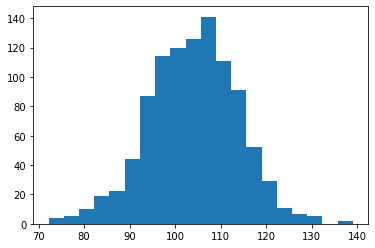

In [28]:
    
#We could use a gaussian defined like this
gau=gaussian_gen(a=-1000,b=1000,name="custom_gaussian") 
gau.set_pars(mean=104,sigma=10)
values=[]
for i in range(10):
    values.append(gau.rvs() )
    
#Norm is more efficient:
values=norm(104,10).rvs(1000)

fig, ax = plt.subplots(1, 1)
nbins = 20
ax.hist(values,nbins)
plt.savefig("gaussian_example.png")


#Define the NLL function
nl=nll(gaussian,values)
mu = 50
sigma = 5
print(nl(mu,sigma))

#Check some of the features:
mea=np.mean(values)
ndof= 1
print ("# Generated points:",len(values)," mean ", mea," error on the mean ",np.std(values,ddof=ndof)/math.sqrt(len(values)))
       
m2 = Minuit(nl,mu,sigma)
m2.migrad()
m2.hesse()
m2.minos()
print("covmatrix",m2.covariance)


print("printing all parameters from minuit minimization")
print ( m2.params )
print("printing covariance matrix")
print ( m2.covariance )
    